<a href="https://colab.research.google.com/github/btrentini/data_science/blob/master/US_Census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#US Census 

⚠ **Run notebook:** In the menu above click "Runtime > Run all" or press $CTRL + F9$   

⚠ Heads up: this takes ~15 minutes on a Google Colab notebook with High RAM instance and a NVIDIA P100 GPU 

## Task Summary

In summary, this noteboo intends to:

- **Extract and Prepare** the dataset from http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
- Provide **relevant EDA and Feature Engineering**
- **Learn**, for a dataset formed by vectors $\{x_n\}_{n=0}^N$, N the number of training examples, a model for the label $y_n$.  
- **Predict**, given an a vector $x_n=\{x_n^0, x_n^1, ..., x_n^K\}$, $K$ the number of features, if target variable, $y$ (income classification), is greater than or equal to \$50,000 per year, yielding a prediction $\hat{y_n}$ for each training example $x_n$.
- **Test different models** and measure performance on test. We want to minimise the cross-entropy loss for the pairs $(y, \hat{y})$ and measure Accuracy, Precision, Recall and F1-Scores. 
- **Highlight pain points** along the process
- **Raise further ideas** about how to improve model performance and redress caveats

## Task Info

The following link lets you download an archive containing an “exercise” US Census dataset: http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
This US Census dataset contains detailed but anonymized information for approximately 300,000 people.

>The archive contains 3 files: 
* A large training file (csv)
* Another test file (csv)
* A metadata file (txt) describing the columns of the two csv files (identical for both)

> **The goal** of this exercise is to model the information contained in the last column (42nd), i.e., whether a person makes more or less than $50,000 per year, from the information contained in the other columns. The exercise here consists of modeling a binary variable.

> Work with Python (or R) to carry out the following steps:
*  Load the train and test files.
* Perform an exploratory analysis on the data and create some relevant visualisations.
* Clean, preprocess, and engineer features in the training data, with the aim of building a data set that a model will perform well on.
* Create a model using these features to predict whether a person earns more or less than $50,000 per year. Here, the idea is for you to test a few different models, and see whether there are any techniques you can apply to improve performance over your first results.
* Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction. 
* Apply your model to the test file and measure its real performance on it (same method as above).

>The goal of this exercise is not to create the best or the purest model, but rather to describe the steps you took to accomplish it.
Explain areas that may have been the most challenging for you.
>Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?
>Finally, you push your code on GitHub to share it with me, or send it via email.

>Once again, the goal of this exercise is not to solve this problem, but rather to spend a few hours on it and to thoroughly explain your approach.

## Metadata Info

**From the metadata (see below how this was obtained):**


This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html

>Donor: Terran Lane and Ronny Kohavi
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.

**Prediction task** is to determine the income level for the person represented by the record.  Incomes have been binned at the $50K level to present a binary classification problem, much like the original UCI/ADULT database.  The goal field of this data, however, was drawn from the "total person income" field rather than the "adjusted gross income" and may, therefore, behave differently than the orginal ADULT goal field.
More information detailing the meaning of the attributes can be found in http://www.bls.census.gov/cps/cpsmain.htm

The data was split into train/test in approximately $2/3$, $1/3$ proportions using MineSet's MIndUtil mineset-to-mlc.

**Note**: We will use the 1/3 above as Test Set and will create another split of 1/3 from the train set as our cross-validation set

# Setup

## Check GPU configs

In [1]:
!nvidia-smi

Sun Sep 27 23:20:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9659906edf50b12c2c9b87c323a23c29671e91e00fe21eecf3b9959b584b5583
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
!pip install imbalanced-learn

In [5]:
!pip install --upgrade seaborn

     |████████████████████████████████| 286kB 7.4MB/s 
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


## Imports

In [6]:
import time
start_time = time.time()

In [7]:
# System utils
import sys
import os
import zipfile

# Parallelism
from joblib import Parallel, delayed

# Some classic data science stuff
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 

# Math & Stats
import math 
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor  

# Machine Learning libs
from sklearn import svm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree

# Scikit learn utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.mixture import GaussianMixture


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# Styling
sns.set_style("ticks", {"xtick.major.size": 11, "ytick.major.size": 11})
sns.set_palette("inferno")
sns.set(font_scale = 2)
figsize=(23, 15)
pal='inferno'
div = "="*72

# Build datasets

## Download & Extract

In [9]:
!wget "http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip"

--2020-09-27 23:21:02--  http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
Resolving thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)... 52.216.138.179
Connecting to thomasdata.s3.amazonaws.com (thomasdata.s3.amazonaws.com)|52.216.138.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9801875 (9.3M) [application/zip]
Saving to: ‘us_census_full.zip’

us_census_full.zip  100%[===================>]   9.35M  12.0MB/s    in 0.8s    

2020-09-27 23:21:03 (12.0 MB/s) - ‘us_census_full.zip’ saved [9801875/9801875]



In [10]:
!ls -1

sample_data
us_census_full.zip


In [11]:
# Define helper to load
local_zip =os.path.join('/content', 'us_census_full.zip')

# Unzip Train Set into temporary path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [12]:
!ls -1 /tmp

__MACOSX
us_census_full


In [13]:
train     = '/tmp/us_census_full/census_income_learn.csv'
test      = '/tmp/us_census_full/census_income_test.csv'
metadata  = '/tmp/us_census_full/census_income_metadata.txt'

## Metadata Investigation

Let's see what's inside....

In [14]:
# Let's see what's in the metadata
!fold -w 130 -s $metadata

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Terran Lane and Ronny Kohavi
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.
|
| The data was split into train/test in approximately 2/3, 1/3
| proportions using MineSet's MIndUtil mineset-to-mlc.
|
| Prediction task is to determine the income level for the person
| represented by the record.  Incomes have been binned at the $50K
| level to present a binary classification problem, much like the
| original UCI/ADULT database.  The goal field of this data, however,
| was drawn from the "total person income" field rather than the
| "adjusted gross income" and may, therefore, behave differently than the
| orginal ADULT goal field.
|
| More information detailing the meaning of the attributes can be
| found in http://www.bls.census.gov/cps/cpsmain.htm
| To make use of the data d

In [15]:
# Check if there's a header in the train file
!head -2 $train

73, Not in universe, 0, 0, High school graduate, 0, Not in universe, Widowed, Not in universe or children, Not in universe, White, All other, Female, Not in universe, Not in universe, Not in labor force, 0, 0, 0, Nonfiler, Not in universe, Not in universe, Other Rel 18+ ever marr not in subfamily, Other relative of householder, 1700.09, ?, ?, ?, Not in universe under 1 year old, ?, 0, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in universe, 2, 0, 95, - 50000.
58, Self-employed-not incorporated, 4, 34, Some college but no degree, 0, Not in universe, Divorced, Construction, Precision production craft & repair, White, All other, Male, Not in universe, Not in universe, Children or Armed Forces, 0, 0, 0, Head of household, South, Arkansas, Householder, Householder, 1053.55, MSA to MSA, Same county, Same county, No, Yes, 1, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in uni

In [16]:
# Check if there's a header in the test file
!head -2 $test

38, Private, 6, 36, 1st 2nd 3rd or 4th grade, 0, Not in universe, Married-civilian spouse present, Manufacturing-durable goods, Machine operators assmblrs & inspctrs, White, Mexican (Mexicano), Female, Not in universe, Not in universe, Full-time schedules, 0, 0, 0, Joint one under 65 & one 65+, Not in universe, Not in universe, Spouse of householder, Spouse of householder, 1032.38, ?, ?, ?, Not in universe under 1 year old, ?, 4, Not in universe, Mexico, Mexico, Mexico, Foreign born- Not a citizen of U S , 0, Not in universe, 2, 12, 95, - 50000.
44, Self-employed-not incorporated, 37, 12, Associates degree-occup /vocational, 0, Not in universe, Married-civilian spouse present, Business and repair services, Professional specialty, White, All other, Female, Not in universe, Not in universe, PT for econ reasons usually PT, 0, 0, 2500, Joint both under 65, Not in universe, Not in universe, Spouse of householder, Spouse of householder, 1462.33, ?, ?, ?, Not in universe under 1 year old, ?, 

In [17]:
# Build DataFrames
%time df  = pd.read_csv(train, header=None)
%time t_df = pd.read_csv(test, header=None) 

CPU times: user 1.21 s, sys: 107 ms, total: 1.31 s
Wall time: 1.31 s
CPU times: user 621 ms, sys: 18.5 ms, total: 639 ms
Wall time: 638 ms


In [18]:
# Check
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


## A trick from metadata for column names
 This will help us a lot during EDA. The metada contains useful information about columns, values and their properties. I can use this file to name columns and later on this will give us the option to address the dataframe by column names, which might be handy in many cases

In [19]:
!tail -42 $metadata

age: continuous.
class of worker: Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay.
detailed industry recode: 0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, 32, 33, 34, 35, 36, 37, 38, 39, 4, 42, 45, 5, 15, 16, 22, 29, 31, 50, 14, 17, 18, 28, 3, 30, 41, 46, 51, 12, 13, 21, 23, 26, 6, 7, 9, 49, 27, 8, 10, 20.
detailed occupation recode: 0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42, 40, 34, 14, 36, 38, 2, 20, 25, 37, 41, 27, 24, 30, 43, 33, 16, 45, 17, 35, 22, 18, 39, 3, 15, 13, 46, 8, 21, 9, 4, 6, 5, 1, 11, 7.
education: Children, 7th and 8th grade, 9th grade, 10th grade, High school graduate, 11th grade, 12th grade no diploma, 5th or 6th grade, Less than 1st grade, Bachelors degree(BA AB BS), 1st 2nd 3rd or 4th grade, Some college but no degree, Masters degree(MA MS MEng MEd MSW MBA), Associates degree-occup /vocational, Associates degree-academic program, Doctorate deg

From the above we can see that the last 42 rows are the column names
We can use this info to improve our datasets and help us eith EDA. Besides, the metada tells us to ignore '|_instance_weight' the 24th record



> 🤕 **Pain Point:** dataset cleaning is an art... platforms like [Dataiku](https://www.dataiku.com/) makes it much easier to repeat and visualise this process. Writing code for this, especially with many datasets, is super time-consuming (but has to be done!)

In [20]:
# We will beed a list to append to...
cols = []

# Save metadata last 42 rows
column_names = !tail -42 $metadata

# Remove the record to be ignored '|_instance_weight'
column_names.pop(24)        

# Build column helper
for col in column_names:
  record = col.split(":")[0].replace(" ","_")
  cols.append(record)

# Add target variable's column not listed in metadata
cols.append("target")

# Insert column names into dataframes
df.columns = cols
t_df.columns = cols

# Voila!
df.head(5)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [21]:
df.target.value_counts()

 - 50000.    187141
 50000+.      12382
Name: target, dtype: int64

**Note:** Dataset quite unbalanced...So we have two options:

- Either do Downscaling / Upscaling; Or
- Create a method that accounts for this imbalance in the proper way

I often prefer the second as we need to model the data's true nature. Advanced techniques exist (deriving from Bayesian Methods, for example), but since I know some "off-the-shelf" models can help us in this classification problem, so I'll focus on them

## Categorise data 

Lets convert objects into categorical values so that we can manipulate them numerically

In [22]:
# This ensures there wont be empty spaces in the strings to avoid
#         creating categories that don't actually exist

obj = df.select_dtypes(['object'])
df[obj.columns] = obj.apply(lambda x: x.str.strip().replace(" ",""))

> 🤕 **Pain Point:** Sometimes we override parts or entire datasets by mistake and then we need to restart the process. Here I am saving checkpoints due to the "continuous" nature of Colab Notebooks, but @Dataiku's DSS platform would make it much easier with visual recipes to prepare the data... 

In [23]:
# Safety backup. In a low-memory / large dataset context I wouldn't do it
df_bkp = df.copy()
t_df = t_df.copy()

for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.strip().replace(" ","").astype('category').cat.codes
    t_df[col] = t_df[col].str.strip().replace(" ","").astype('category').cat.codes

df.dtypes

age                                             int64
class_of_worker                                  int8
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                        int8
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                       int8
marital_stat                                     int8
major_industry_code                              int8
major_occupation_code                            int8
race                                             int8
hispanic_origin                                  int8
sex                                              int8
member_of_a_labor_union                          int8
reason_for_unemployment                          int8
full_or_part_time_employment_stat                int8
capital_gains                                   int64
capital_losses                                  int64
dividends_from_stocks       

## Are there null / undefined values?

There are a few records marked with "$?$" but we will treat these as a category... I understand "unkown" values also have their importance for some models. **Another option:** I could infer the values of "?" based on the dataset, but that's a different task and may require some time...

I could also "exclude" all rows containing "?" but I may as well lose important information.


In [24]:
null_columns=df.columns[df.isnull().any()]
if len(null_columns) > 0:
  print(df[null_columns].isnull().sum())
else:
  print("No null columns")

na_columns=df.columns[df.isna().any()]
if len(na_columns) > 0:
  print(df[na_columns].isna().sum())
else:
  print("No NA columns")

No null columns
No NA columns


## Are there duplicates?

In [25]:
if df.duplicated().sum() > 0:
  print(df.duplicated().sum(), " dupicated records found and dropped")
  df.drop_duplicates(inplace=True)

3229  dupicated records found and dropped


# Feature Engineering

We not necessarily need to add more features to our dataset. In fact, for binary classification models in many cases we have more features than we need. We can go a lot deeper in the analyses to come up with good features. 

For example, *in 1995 the average workweek for men was 42.1h and 35.8h for woman* according to the report [Hours of Work Since the Mid-70's](https://www.bls.gov/opub/mlr/1997/04/art1full.pdf) compiled by Philip L. Rones, former Assistant Commissionerfor Current Employment Analysis, Bureau of Labor Statistics. The study also pointed that persons aged 25-54 worked more hours than older and younger people. Besides, workweek hours was also influenced by industry (Agricultural workers had a different schedule than most "office" workers) and marital status (married men tended to work more hours than married woman). There's also a distribution on work hours within each group (for examle, only 46% of people aged 25 to 54 years would work 40h a week). Therefore, we can go super deep into feature engineering, but we will make good (but rather loose) assumptions. **For example, the study points out the average workweek was 39.2h**. We don't have this feature and this alone don't bring a lot more insights than "weeks_worked_in_year". But it can be useful to calculate "total_income"

> "Sex" is not balanced (we have circa 8% more females than males in our trianing set). For this reason we will use Pilip L. Rones individual averages to compute new features. 

Therefore, it would make sense to create a feature for total income $I = \overline{h}_{sex} * w * H$. Where $I$ is the total income in a year, $\overline{h}_{sex}$ is the average weekly hours by sex, $w$ is the total number of weeks worked in a year and $H$ the total number of hours worked per week. 

Let's see if that feature will contribute to our model:

[Text(0, 0, 'Female'), Text(0, 0, 'Male')]

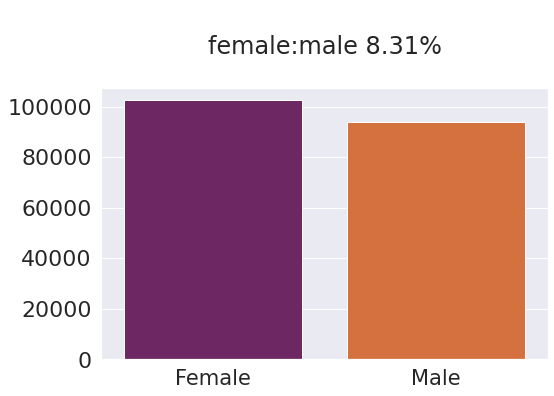

In [26]:
fig, ax=plt.subplots(figsize=(8,5))
sex_balance = 1-(df[df.sex == 1].sex.value_counts().values[0] / df[df.sex == 0].sex.value_counts().values[0])
sns.barplot(x=df.sex.unique(), palette=pal, 
            y=df.sex.value_counts().values).\
            set_title('\nfemale:male {}%\n'.format(round(100*sex_balance,2)));

plt.xticks(rotation=0, fontsize=21)
ax.set_xticklabels(['Female', 'Male'])

In [27]:
print("We have wage AND weeks worked for {}% of the dataset".format(
    round(100*len(df[(df.wage_per_hour!=0) & (df.weeks_worked_in_year!=0)])/len(df),2)))

We have wage AND weeks worked for 5.61% of the dataset


Since we have many '0's in the weeks_worked_in_year and wage_per_hour fields (~95% of the dataset), we get would get $I$ for only 3% of the records. 

That doesn't look very promising... *I honestly think this feature will harm the model since we have so limited data to calculate total annual income...but I won't pretend I didn't consider it :)*

> 😫 **Pain point**: For now I won't create a lot of features as I don't know how an initial model performs and am not sure about the bias/variation trade-off in this case.... Usually feature engineering requires many lines of code. Dataiku would make it so easy with a recipe and documentation of model performance.

# Technical EDA 

In this section our objective is to find correlations and potential risks of collinearity. Demographics EDA is next.

## Feature Importance

Let's begin with a simple light GBM for estimating feature importance. 

This model could be used for predictions, but just to have some variablity, I will use this for feature estimation and XGBoost for modelling / predictions. The same model could be used for both purposes... 

In [ ]:
model = LGBMClassifier(learning_rate=0.01, num_leaves= 33, random_state=77)
model.fit(df.iloc[:,:-1], df.iloc[:,0])

In [ ]:
fig, ax = plt.subplots(figsize=(figsize))
ax = sns.barplot(y=model.feature_importances_, x=df.iloc[:,:-1].columns, palette=pal)
plt.xticks(rotation=90)

🚨 *INTERESTING!*

**This is very strange!** in real life we know that age, although a good indicator, can't play alone such an important weight in determining someone's income. There must exist some colinearity in the data (or worse things!). Let's check:

## Correlation

Tjhis will help us understand risks of colinearity and some features that we can scrap. We will only consider removing features with moderate (>0.5), strong (>0.7) and very strong (>0.9) correlation in absolute values

In [ ]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

### Variance Inflation Factor(VIF)
From WikiPedia: VIF is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

> Multicollinearity is a common phenomenon in high‐dimensional settings, in which two or more predictor variables are highly correlated [Zhao et al, 2020]( https://doi.org/10.1002/sta4.272)

This is a bit of a controversial topic and "tule of thumb" tresholds are dangerous as pointed in [A Caution Regarding Rules of Thumb
for Variance Inflation Factors](https://www.researchgate.net/profile/Robert_Obrien8/publication/226005307_A_Caution_Regarding_Rules_of_Thumb_for_Variance_Inflation_Factors/links/54d0f2620cf298d656695641/A-Caution-Regarding-Rules-of-Thumb-for-Variance-Inflation-Factors.pdf). The lowest VIF valuee is 1. Anything beyond 10 is extreme. Most people choose either $3$, $4$ or $5$ as treshold. We will go with $4$.

❌ We have $k=41$ features. With large $k$ this would be innapropriate but there are solusions like the one proposed in [Zhao et al, 2020]( https://doi.org/10.1002/sta4.272)


In [ ]:
X = add_constant(df.iloc[:,0:-1])
multico_indx=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

In [ ]:
sns.distplot(multico_indx, rug=True)

In [ ]:
df.iloc[:,np.where((multico_indx[1:] < 4)==True)[0][:].tolist()].dtypes

In [ ]:
df = df.iloc[:,np.where((multico_indx[1:] < 4)==True)[0][:].tolist()]
df['target'] = df_bkp['target'].astype('category').cat.codes

In [ ]:
df.head(5)

### Post-VIF check feature importance

In [ ]:
model = LGBMClassifier(learning_rate=0.01, num_leaves= 33, random_state=77)
model.fit(df.iloc[:,:-1], df.iloc[:,-1])

fig, ax = plt.subplots(figsize=(figsize))
ax = sns.barplot(y=model.feature_importances_, x=df.iloc[:,:-1].columns, palette=pal)
plt.xticks(rotation=90)

> **✅ That makes more sense!**
We now see a greater importance of "Capital Gains" and "Capital Losses" and "Dividends". Indeed, if someone has the profile of an investor, it might be a good indicator that this person earns > 50K

Likewise, **age, education, industry**.... are also factorrs we normally understand as a good indicator of someone's income (sometimes by common sense / experience). *Therefore, as we can see, our feature selection makes sense*. There are still some "unimportant" features, but for now we can leave them as they can help reduce the "weights" of our predictions and / or produce a more general model (we will see!)

### Post-VIF check correlation

In [ ]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

## Remove not-so-important features and / or with moderate correaltion or higher

This is due to mathematical requirements. We want to avoid singularities and undetermined matrices in our algorithms.

It Looks like country of birth from father and mother are moderately correlated with citizenship. Since we can (almost) always derive someone's citizenship from their parents' place of birth and assuming parents' nationality do not play an imediate factor in someone's wages (setting apart deeper social analyses) and considering neither parent's origin appears as a crucial feature in our Light GBM model, we will remove these features to simplify our model further

In [ ]:
df.drop(columns=['country_of_birth_father'], inplace=True)
df.drop(columns=['country_of_birth_mother'], inplace=True)

There's a moderate linear relationship between the industry of a person with its ocupation and the number of persons worked for employer. Althought these shouldn't affect our model aggressively, we can infer one by the other (for instance: we assume that someone's occupation is highly related to its industry and that its industry can tell information about the number of people per employer. Think about Social Media industry versus Manufacuring plant.)

In [ ]:
df.drop(columns=['detailed_occupation_recode'], inplace=True)
df.drop(columns=['num_persons_worked_for_employer'], inplace=True)

We can see in [Hours of Work Since the Mid-70's](https://www.bls.gov/opub/mlr/1997/04/art1full.pdf) compiled by Philip L. Rones, former USA Assistant Commissioner for Current Employment Analysis, Bureau of Labor Statistics, that marital status can influence totall income (married people tend to work less hours in a week, according to his 1995 report). The EDA also reveleaded that "Age" is an important factor. So...

**From the metadata**
> tax filer stat: Nonfiler, Joint one under 65 & one 65+, Joint both under 65, Single, Head of household, Joint both 65+.

We see a "duplication" between this and *marital_stat* and *age*...So This will not add extra info that we haven't already obtained... so we will get rid of that

In [ ]:
df.drop(columns=['tax_filer_stat'], inplace=True)

Let's visualise it again: no moderate correlations or worse

In [ ]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  #ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=False, 
              fmt=".2f",
              robust=True,
              cbar=True,
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

**NICE!** *So no correlations greater than 0.5 or less than -0.5. Let's plot the rest:*

In [ ]:
correlation = df.drop(['target'], axis=1).corr()
mask = np.triu(correlation)
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(23,23))
  #ax = sns.heatmap(correlation[(correlation > 0.5) | (correlation < -0.5)],
  ax = sns.heatmap(correlation,
              square=True,
              vmax=1.0,
              vmin=-1.0,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              mask=mask,
              annot=True,
              fmt=".1f",
              robust=True,
              cbar=True,
              annot_kws={"size": 16},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

# Demographics EDA

We now know the most important features, *according to the lightGBM model*. Let's try to get further insights from this by exploring our data a little further and then come up with a simple hypothesis to test and a prediction model.

We will create a new dataset keeping the categories just for analysis!

> 🤕 **Pain Point:** I wish I could have a 'recipe' for obtaining the cateories and keep the data analysis unafected without having to 'allocate more stuff' in memory... 

In [ ]:
# Lets use the non categorized dataset for some analyses
eda = df_bkp.loc[:, df.columns.tolist()]

## Understanding Age better


**Warm up:** Age was pointed as an important feature. Do we have a population that is equally distirbuted in terms of age? 

No. We can see that 50% of the population is 35 years old or younger. We have the next 30% at circa 60 years old or less. We can also confirm that by fitting a log-gama distribution over the data (second chart, black line).

By the manifest we know this data comprises the years 1994 and 1995. Therefore, **we can do some fact checking**: we see that indeed between 1990 and 2000 the median age of the United States was around 35 years old (despite the fact the census data only includes the Economic Active Population)

<a href="https://www.statista.com/statistics/241494/median-age-of-the-us-population/" rel="nofollow"><img src="https://www.statista.com/graphic/1/241494/median-age-of-the-us-population.jpg" alt="Statistic: Median age of the resident population of the United States from 1960 to 2019 | Statista" style="width: 100%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a><br />Find more statistics at  <a href="https://www.statista.com" rel="nofollow">Statista</a>

In [ ]:
# Bimodal data, 50% of population less than 35yo
fig, ax = plt.subplots(2, 1, figsize=figsize)
kwargs = {'cumulative': True}

g1 = sns.distplot(eda['age'], hist_kws=kwargs, kde_kws=kwargs, ax=ax[0], axlabel=None,
                  fit=stats.gamma, bins=10)
g2 = sns.distplot(eda['age'], rug=True, ax=ax[1], fit=stats.loggamma)

How about the target by age? We can see that 50% of those earning $< 50$K are around 30~35 years old or younger. On the other hand, 50% of those earning $>50$K are older than 45 years .

In [ ]:
fig, ax = plt.subplots(figsize=(figsize))
g = sns.boxplot(y='age', x='target', data=eda, palette=pal)
plt.xticks(rotation=0)

As expected, **age** will play a role in our predictions. Common knowledge tells us that, in rare expections, someone who's starting their career will earn less than someone at more senior levels (usually a consequence of experience that comes with ageing). Likewise, retired people tend to earn less than those who are economically active.  This is a straight-forward assumption. **So let's try some more involved hypothesis without looking into the data.**


## Understand Capital Gains versus Age

We will combine stocks performance (this will become a new feature later on!) to see if "investors profile" have higher wages

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
cap = eda.capital_losses - eda.capital_losses + eda.dividends_from_stocks 

sns.scatterplot(x="age", y=cap.values,
                hue="target", 
                palette=pal,
                sizes=(1, 8), linewidth=0,
                data=eda, ax=ax)

plt.suptitle("Stock Performance  as a function of Age and their influence in total income")

Judging by this plot: there are several people who make +50K as income, but whose stocks gain are below 20,000. This means that a "investor" profile may not necessarily make more than 30,000 in a "usual" job. Besides, we see some outliers: people making 100K+ in stocks alone

## Other Social Indicators vs Income
We will explore if social indicators such as  Sex, Race, Citizenship has any pattern in regards to the target variable

### Age groups and nationalities

In [ ]:
g = sns.catplot(x="target", y="age",
                hue="race", col="sex",
                palette=pal, legend=False,
                data=eda, kind="box");
g.fig.set_size_inches(23,13)
plt.legend(bbox_to_anchor=(0.85,-.15), ncol=len(eda.race.unique().tolist()))
plt.xticks(rotation=0);

Interesting... It seems like although "White" and "Black" races are quite balanced in terms of spread of age (disconsidering outliers) for males, but not for females where "Blacks" are somehwat younger (3rd quantile closer to 40s than 60s).

As for the other races, there's clearly a concentration of younger people regardless of their income group. What stands out is the presence of 'other' races where the majority of people making under 50K are around 20 years old for both makes and females. Let's go deeper into that.

**Deep Dive into 'Other':**

In [ ]:
# We already check if there are NAs or nulls, so we can safely count with
f, ax = plt.subplots(figsize=figsize)
y = eda[eda.race=='Other'].groupby('citizenship').age.count().values
x = eda.citizenship.unique()

ax = sns.barplot(x=x, y=y, palette='cividis')
plt.xticks(rotation=90, fontsize=23)

Ok. We have a mix of backgrounds here, with the majority being from Puerto Rico or US Outlying. The total number of people in this category is immaterial, **so shouldn't influence our predictions too much**. **Just out of curiosity, let's check their demographics.**

**⚠** **ATTENTION**: Plots have been inverted. Argument order=['A', 'B'] of catplot did not work this time.

In [ ]:
g = sns.catplot(x="race", y="age",
                hue="citizenship", col="sex",
                palette=pal, legend=False, legend_out=False,
                data=eda[eda.race == 'Other'], kind="box");

plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0,-0.15))
g.fig.set_size_inches(23,23)
plt.xticks(rotation=0);

### Education influence on income group

In [ ]:
aux = pd.DataFrame(eda.groupby(['target', 'education']).\
                   age.count(), index=None).reset_index().\
                   rename(columns={'age': 'count'}).\
                   sort_values(by=['target','count'], ascending=False).reset_index()

g = sns.catplot(x="education", y="count",
                hue="target", col="target", sharey=False,
                data=aux, kind="bar", palette=pal)

g.fig.set_size_inches(15, 8)
g.set_xticklabels(fontsize=15, rotation=90)

**It is clear that the data is skewed** with more people in the lower income group (probability of picking someone at random and get income group = -50K is 93%, according to the metadata).Nonetheless, we can see that people with less income are, in its majority, from lower educational backgrounds while the group earning +50K have, in its majority, at least a Bachelor's Degree. 

## Relation between (some of the) most important features

In [ ]:
sns.relplot(
    data=eda, height=18, aspect=0.5,
    x="age", y="education", col='sex',
    hue="target", size=cap,
    palette=pal, sizes=(10, 200),
)
g.set(xscale="log", yscale="log")
g.despine(left=True)
plt.yticks(fontsize=13)
#plt.legend(loc='lower center', bbox_to_anchor=(0.35,-0.35), ncol = 4)

**Look how interesting:** there's a strong indication that higher education leads to more stock investments (juding by the circle sizes), which leads to higher annual income (juding by the color). The circles sizes represent how much investment there's in the stock market.

One concern: children in the data? Child labour? Error in the data....? This might be beyond our goal for EDA for today!

Another interesting point is the difference between Male x Female in "High School Graduate" education level. This 1995 data. Perhaps it has changed a lot since then? (We hope so!).

At least from Master's level, sex disparity is not so aggressive. For PhDs we again see more men than women in the top-tier earning

This presentation from the US Census Bureau shows important changes in demographics since 1995: https://www.census.gov/newsroom/pdf/women_workforce_slides.pdf 



> The EDA above helps us further understand the relationships between the data point and the target variable and reveal deeper social issues to be investigated. **Indeed the EDA** above helps us have reasonable assurance that the lightGBM model has classified feature importance in a meaningful way. We can proceed to some hypothesis testing and the classification / prediction task.

In [ ]:
## Release memory, things not needed go to trash
del aux 

# Hypothesis Test 1: Constructors vs Educators

**Let's pretend we have some questions and distill the following hypothesis without looking into the data (only using statistics)**

"There's a better chance of seeing more *Construction* workers among the top earners in comparison to *Education* workers"

>$H_0: \, \, $ Equal chances of *Construction* workers and *Education* workers to earn +50K  ($\theta=0.5$)    
>$H_1: \, \, $ There's a higher chance of *Construction* workers to b earning earning  +50K versus *Education* workers ($\theta > 0.5$)  


Where $H_0$ is our null hypothesis and $H_1$ is our alternative hypothesis, our test will be conducted at a significance level of 5%


🚀 Let's skip EDA for the industry and try to answer two hypothesis with the high level of confidence in a statistical way



In [ ]:
# Let's first compute the proportion of construction workers and educators among the top earners
test_statistic = eda[(eda.major_industry_code=="Construction")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]
complement = eda[(eda.major_industry_code=="Education")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]

# How many observations do we have in total
N = test_statistic+complement

# And for each of our target observations
print("Total Construction and Education Workers earning +50K = ", N, test_statistic+complement==N)
print("--- construction =", test_statistic)
print("--- education =", complement)

**To simplify, we can model this as a binomial distribution** (seeing construction workers in the high earning group is considered success)

*Level = 5%*:  Decreasing this will decrease our critical region (region where we fail
 o reject the null hypothesis if the p-value falls within)

*p=0.5:*  We want to test if the propability of seeing constructors and educators are the same

In [ ]:
level=0.05
p=0.5

In [ ]:
print(f"Within the 50K+ target we have seen {N} constructors and educators")
print(f"{test_statistic} of them are in the Construction Sector ({round(test_statistic/N,2)*100}%)\n")
print(f"\nH0 : The proportion of consutrction workers as top earners is the same as educators (param = {p})")
print(f"H1 : There are fewer construction workers earning 50K+ than educators (param < {p})\n")

%time p_value = np.sum([stats.binom_test(x, N, p=0.5, alternative='greater') for x in range(test_statistic)])

print("\n\t Sum p-values", p_value)

print("\n", div)
if p_value < level:
  print('''\nTHEREFORE We reject the null hypothesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  Considering only educators and constructors,
  the observation is not due to chance
  \n>> Constructors and Educators are not equally likely among the top earners\n''')
else:
  print('''\nTHEREFORE We FAIL to reject the null hypotehesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  Considering only educators and constructors,
  the observation is not due to chance
  \n>> constructors and educators are balanced as top earners\n''')
print(div)


# Hypothesis 2: What if we compare Education against Entertainment workers? 

**Let's distill the following hypothesis:**

"US is the land of Holywood and we know many people don't have access to good education. So Education workers are less prone to be among top earners (50K+) than Entertainment workers". 

>$H_0: \, \, $ Equal chance of *Education* workers earning  +50K,as *Educators* workers   ($\theta=0.5$)    
>$H_1: \, \, $ There's a lower chance of seeing *Education* workers earning  +50K in comparison to *Entertainment* workers ($\theta < 0.5$)  


Once again, $H_0$ is our null hypothesis and $H_1$ is our alternative hypothesis, our test will be conducted at a significance level of 5%


🚀 No EDA, yes Stats.



In [ ]:
# Let's first compute the proportion of construction workers and educators among the top earners
test_statistic = eda[(eda.major_industry_code=="Education")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]
complement =  eda[(eda.major_industry_code=="Entertainment")].groupby("target").count().T.reset_index().iloc[:,0:3].iloc[0][2]

# How many observations do we have in total
N = test_statistic+complement
print("Total Education and Entertainment workers earning +50K = ", N, test_statistic+complement==N)
print("--- Education =", test_statistic)
print("--- Entertainment =", complement)

In [ ]:
level=0.05
p=0.5

In [ ]:
print(f"Within the 50K+ target we have seen {N} Educators and Entertainers")
print(f"{test_statistic} of them are in the Educators Sector ({round(test_statistic/N,2)*100}%)\n")
print(f"\nH0 : The proportion of Educators workers as top earners is the same as Entertainers (param = {p})")
print(f"H1 : There are fewer Education workers earning 50K+ than Entertainers (param < {p})\n")

%time p_value = np.sum([stats.binom_test(x, N, p=0.5, alternative='less') for x in range(test_statistic)])

print("\n\tSum p-values", p_value)

print("\n", div)

if p_value < level:
  print('''\nTHEREFORE We reject the null hypothesis H0.
  There is enough evidence at 5% level of significance to suggest that,
  Considering only Educators and Entertainers,
  the observation is not due to chance
  \n>> there are more Educators than Entertainers in the top earners\n''')
else:
  print('''\nTHEREFORE We FAIL to reject the null hypotehesis H0.
  There is enough evidence at 5% level of significance to suggest that 
  the observation is not due to chance
  \n>> Educators and Entertainers are balanced among top earners\n''')
print(div)


# Machine Learning

🚨 **HEADS UP** We will first try some models on the Test and Validation Sets and assess performance of all models in the test set later on!

> 🤕 **Pain Point**: some models can take a long time to run. If only I could easily track performance "on-the-fly"... Especially Deep Learning models, it's so frustrating when you tune hyperparameters and it doesn't converge...

> 🤕 **Paint Point**: I wish there was a better way to document hyperparameter testing so I can retrieve the best model (Grid Search might do, but I wish I could have more control upon feature selection, hyperparams and checkpoints....)


> Tip: Dataiku DSS could easily help me resolve these...


## Split Train into Train (70%) & Validation (30%)

In [ ]:
X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()
xtest = t_df.iloc[:,:-1].copy()
ytest = t_df.iloc[:,-1].copy() 

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=77, shuffle=True)

## XGBOOST
Please note this is not the Scikit-learn API but the python API: https://xgboost.readthedocs.io/en/latest/python/python_intro.html which provides better support for GPUs

In [ ]:
# instantiate params
params = {}

# general params
general_params = {'silent': 1,
                  'lambda': 0.02,
                  'learning_rate': 0.07,
                  'max_depth': 16}
params.update(general_params)

# booster params
n_gpus = 1  # change this to -1 to use all GPUs available or 0 to use the CPU
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus   
params.update(booster_params)

# learning task params
learning_task_params = {}
learning_task_params['eval_metric'] = ['logloss']
learning_task_params['objective'] = 'reg:logistic'

params.update(learning_task_params)

In [ ]:
xgboost_model = XGBClassifier(**params, n_estimators=1000, early_stopping_rounds=10, verbose=2)

In [ ]:
print("Train...")
%time xgboost_model.fit(xtrain, ytrain)

print("\nPredict (Validation)...")
%time y_pred = xgboost_model.predict(xvalid)
predictions=[round(value) for value in y_pred]

### Prediction on Validation Set

In [ ]:
# This is how many records we have in the validation set
pd.Series(yvalid).value_counts()

In [ ]:
accuracy = accuracy_score(yvalid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(yvalid, y_pred))
print("RMSE: %f" % (rmse))

In [ ]:
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(yvalid, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on VALIDATION Set", fontsize=27)

In [ ]:
print(classification_report(yvalid,predictions))

Not so good performance on class +50K (because our data is skewed. As stated in the medatada: picking someone at random will give us 93% chance of selecting someone on the -50K group)

###  XGBoost with balanced and normalised data 

Let's try to normalise and upscale our '50K+' class. 

Ask me why I am not a big fan of upscaling...the explanation deserves a whole "Colab Notebook" 

In [ ]:
X = df.iloc[:,:-1].copy()
y = df.iloc[:,-1].copy()

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X = pd.DataFrame(X, columns=df.iloc[:,:-1].columns)
y = pd.Series(y); 

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3, random_state=77, shuffle=True)
scaler = Normalizer().fit(xtrain)

In [ ]:
xg_boost_model_norm = XGBClassifier(**params, n_estimators=1000, early_stopping_rounds=10, verbose=2)

print("Train...")
%time xg_boost_model_norm.fit(xtrain, ytrain)

print("\nPredict (Validation)...")
%time y_pred = xg_boost_model_norm.predict(xvalid)
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(yvalid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(yvalid, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(yvalid, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nConfusion Matrix on VALIDATION Set", fontsize=27)

print(div)

In [ ]:
print(classification_report(yvalid,predictions))

## SVM

Since this seems like a linear model, an alternative method to explore would be SVM. However, SVMs depend on "support vectors" and their large margins. It is very sensitive to unbalanced datasets e the data must be scaled (some people use PCA).

SVM is robust, but it is time consuming with complecity that can reach $O(N^2*K)$. It is prohibitive unless we  use ensemble methods. 




## Gaussian Mixture Model - GMM

In many times I prefer using GMM over KNNs because it gives us the probabilisitic treshold (soft classification). Which we can use for stacking. In this example, I will a simple model for the sake of comparisons

In [ ]:
gmm = GaussianMixture(n_components=2, 
                      tol=1e-4, 
                      max_iter=10000, 
                      init_params='kmeans', 
                      random_state=77,
                      verbose_interval=100,
                      verbose=1)

%time gmm.fit(xtrain)
predictions = gmm.predict(xvalid) 

In [ ]:
accuracy = accuracy_score(yvalid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(yvalid, predictions))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(yvalid, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\n GMM:: Confusion Matrix on VALIDATION Set", fontsize=27)

print(classification_report(yvalid,predictions))

**How very terrible!** 

This is a fast but poorly performing model due to the data's nature. Although we have two classes, they don't resemble "a mixture" model: in higher dimensions we will have overlaps in the feature space which the GMM can't handle easily unless we do massive data munging or perform further tests **(a chi-square test would give us a good indication wether GMM is a good model, but I wanted to show a model with poor performance!)**


## Deep Learning
I don't see why using deep learning in this scenario. But let's do it just for the sake of comparison (and out of curiosity)

This type of classification problem seems ideal for tree-based and ensemble methods that combine weak-learners. DNN sound very _sexy_ (and hyped) but in fact that can be overkill in many linear problems (DNN are great for Computer Vision, Speech Recognition...). Especially in our case, our dataset $N$ - number of training examples - and $K$ - number of features - is not super large so there's little benefit a more complex model can bring. Besides, a vanilla-DNN (multilayer perceptron) may be just as good as logistic regression model, which is less complex than XGBoost.

> 🤕 **Pain Point** "coding" Deep Learning is a repetitive task. @Dataiku makes it so much easier to run DL models...fine tune hyperparameters...

I will not spend too much time on Hyperparameter tuning. 

Since this is a fairly "light" dataset, I'll leave it run for 50K epochs without patience or early stopping (I'd never do these arbitrary choices in real life!)

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim

In [ ]:
dtype = torch.float
device = torch.device("cuda:0") # We have a GPU!

In [ ]:
nnx_train = torch.tensor(np.array(xtrain).astype(np.float32), device=device)
nny_train = torch.tensor(np.array(ytrain).astype(np.float32), device=device)
nnx_valid = torch.tensor(np.array(xvalid).astype(np.float32), device=device)
nny_valid = torch.tensor(np.array(yvalid).astype(np.float32), device=device)

In [ ]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 18)
    self.fc2 = nn.Linear(18, 11)
    self.fc3 = nn.Linear(11, 5)
    self.fc4 = nn.Linear(5, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

deep_net = Net(nnx_train.shape[1])

In [ ]:
loss_fn = torch.nn.BCELoss()

learning_rate=1e-5
optimizer = torch.optim.Adam(deep_net.parameters(), lr=learning_rate, 
                             weight_decay=0.01) #Adam is a pretty common one

tloss = []
vloss = []
tacc = []
vacc = [] 

deep_net = deep_net.to(device)
loss_fn = loss_fn.to(device)

def acc(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1) # if below 0.5, then -50K
  return (y_true == predicted).sum().float() / len(y_true)

epochs = 50000
for epoch in range(epochs):

  y_pred = deep_net(nnx_train.float())
  y_pred = torch.squeeze(y_pred.float())
  tloss.append(loss_fn(y_pred, nny_train).item())
  tacc.append(acc(nny_train, y_pred).cpu().detach().numpy().item())

  yvalid_pred = deep_net(nnx_valid)
  yvalid_pred = torch.squeeze(yvalid_pred) 
  vloss.append(loss_fn(yvalid_pred, nny_valid.float()).item())
  vacc.append(acc(nny_valid, yvalid_pred).cpu().detach().numpy().item())

  if epoch % 500 == 0:
    print(f'''epoch {epoch} 
    TRAIN ---> loss: {round(tloss[-1],2)} \t accuracy: {100*tacc[-1]}
    VALID ---> loss: {round(vloss[-1],2)} \t accuracy: {100*vacc[-1]}
    ''')
    print(div)


  optimizer.zero_grad()
  loss_fn(y_pred, nny_train).backward()
  optimizer.step()


In [ ]:
data = {'train_loss'  : tloss,
        'train_acc'   : tacc,
        'valid_loss'  : vloss,
        'valid_acc'   : vacc}
results = pd.DataFrame.from_dict(data)

In [ ]:
f, axs = plt.subplots(1,2, figsize=(17,8))

axs[0].plot(results.train_acc)
axs[0].plot(results.valid_acc)

axs[1].plot(results.train_loss)
axs[1].plot(results.valid_loss)

axs[0].set_ylim(ymin=0.4, ymax=1)
axs[1].set_ylim(ymin=0.0, ymax=max(np.max(vloss), np.max(tloss)))

axs[0].set_xlim(xmin=0.0, xmax=epochs)
axs[1].set_xlim(xmin=0.0, xmax=epochs)

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Loss')


axs[0].set_title('Accuracy')
axs[1].set_title('Loss')


classes = ['-50K', '+50K']

predictions = deep_net(nnx_valid)
predictions = predictions.ge(.5).view(-1).cpu()
y_test = yvalid

print(classification_report(yvalid,predictions, target_names=classes))

This is far too easy dataset for Deep Learning. Loss decreases very quickly, but accuracy is not yet pair with XGBoost. We would require lots of fine-tuning to get it to 98% accuracy. For this particular case, as mentioned, tree-based methods seem to be the best choice.

**Good outcomes:** a ~85% accuracy on a "toy" example doesn't sound *too bad*... Besides, it performed worse than XGBoost on classifying both "-50K" and "-50K" with the oversampled and normalised data. The architecture I have used is rather simple and accounts for non-linearity, so perhaps adding more features, in this case, could help.

# Evaluations on Test Set

## XGBoost (Standard) on Test Set

In [ ]:
# This is how many values we have in the Test Set
ytest.value_counts()

print("\nPredict (Test)...")
y_pred=xgboost_model.predict(xtest[df.iloc[:,:-1].columns])
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nXGBoost:: Confusion Matrix on Test Set", fontsize=27)
print(classification_report(ytest,predictions))

## XGBoost (Normalised, Oversampled) on Test Set

In [ ]:
print("\nPredict (Test)...")
y_pred = xg_boost_model_norm.predict(xtest[df.iloc[:,:-1].columns])
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\n XGBoost (Norm, Upscaled):: Confusion Matrix on Test Set", fontsize=27)

print(classification_report(ytest,predictions))

> **Oh no! It seems like that the SMOTE method makes us overfit in the validation set.** I still prefer the non-scaled method as it helps us generalise better onto unseen data.

## GMM on Test Set

In [ ]:
print("\nPredict (Test)...")
y_pred = gmm.predict(xtest[df.iloc[:,:-1].columns])
predictions=[round(value) for value in y_pred]

accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(ytest, y_pred))
print("RMSE: %f" % (rmse))

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\nGMM : Confusion Matrix on Test Set", fontsize=27)

print(classification_report(ytest,predictions))


**Interesting** overall performance on the test set was much better than in the validation set (relative only to the GMM model). This is a clear example of high bias in the training vs validation set. Yet, it seriously fails on class 1 (50K+) due to the limited data in the test set (we don't upscale the test set!)

## Deep Learning on Test Set

In [ ]:
nnx_test = torch.tensor(np.array(xtest[df.iloc[:,:-1].columns]).astype(np.float32), device=device)

In [ ]:
classes = ['-50K', '+50K']

predictions = deep_net(nnx_test)
predictions = predictions.ge(.5).view(-1).cpu()
y_test = ytest

with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(13,13))
  ax = sns.heatmap(confusion_matrix(ytest, predictions),
              square=True,
              center=0.0,
              cmap="coolwarm",
              linecolor='white',
              linestyle = '--',
              rasterized=False,
              edgecolor='white',
              capstyle='projecting',
              linewidth=2,
              annot=True, 
              fmt="d",
              robust=True,
              cbar=False,
              yticklabels=["-50K", "50K+"],
              xticklabels=["-50K", "50K+"],
              annot_kws={'fontsize': 17},
              cbar_kws={"location": "top",
                        'use_gridspec': False,
                        "label": "Correlation Coefficient",
                        'shrink': 0.8})

plt.suptitle("\n Deep Learning:: Confusion Matrix on Test Set", fontsize=27)

print(classification_report(ytest,predictions, target_names=classes))

## Conclusion / Model Selection

Choosing which model to go head depends on the objective and the metric. But we can say that, in this particular case, without much tuning, XGBoost in its standard version is a sufficiently good model (in comparison to others).

In [ ]:
end_time = time.time()
elapsed = end_time - start_time
print(div)
print("Elapsed Time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed)))
print(div)

#THE END ✌


**Some questions to reflect upon:**

1. **Normalise / scale the data?**
SVM exploits distances and similarities from large margins so it needs some sort of scaling to avoid creating support vectors that are wrongfully importance. I chose Normalisation because it uses 'l2' norm and makes the data resemble a gaussian distribution which is almost always convenient for probabilistic models. This form of scaling is good for the linear kernel on SVMs, but XGBoost is a tree based ensemble, which is scale invariant, so it doesn't require scaling. This is evidenced by the fact that XGBoost scaled and normalised performed well on validation set, but faily simililarly on Test Set

2. **Caveats with oversample / downsample?**
I prefer modelling upon the true nature of the data, choosing models that are less sensitive to scale imbalance or that accounts for it in a proper way. There are several other techniques to deal with this issue such as downsampling, stratified oversampling, etc... 

3. **No feature creation?**
We have a dataset that is not very large and that is not showing signs severe overfitting given the results in the validation and test sets on Standard XGBoost. So the trade-off bias / variance shouldn't be a great issue for this particular model. With 41 features and less than 200K training examples, feature engineering might be overkill and lead to overfitting. It's better to first come up with a good model. *The metadata* states: *Probability for the label '- 50000' : 93.80% *and *Probability for the label '50000+' : 6.20%*, so in this dataset it is not so straight-forward to shoot new features into the model. As for the other models, we have oversampled the data, so, as expected, with exception of GMM, they perform well on validation set and worse on test set. These are signs of overfitting and in this case feature engineering (for example, creating polynomial features) could help, especially in the Deep Learning model which handles well non-linearity.

5. **More EDA?**
Since I knew the objective was classification over a linearly-separable setting, I focused on EDA for model preparation understanding rather than trying to understand US' macroeconomy. There are several questions to ask (more hypothesis) such as the relationship between race, sex and wage. Wether citizenship is related to industry, etc.... it depends on the objetive of the analysis. 

6. **Deep Learning?**
Overkill for a (relatively) small mostly-linearly-separable training set. As we can see, decent performance (how much is good enough?) is obtained with XGBoost straightaway 

7. **Future work?** Defintely. There are so many ways to improve this notebook. More experiments, more models, more EDAs, use of external data, change the target variable. We could try model ensembles, stacking, etc.... In short, there are many possibilities to explore and this can be an (theoretically) endless notebook